# Automated concrete crack detection for efficient structural assessment
#### Institute of Data Capstone project
#### Simon Leighton, 19 May 2023
  
  
## Introduction

Comprehensive building assessments combined with regular maintenance plays a crucial role in ensuring the long-term stability, safety, and functionality of man-made structures. All buildings require constant maintenance and repairs to offset the damage caused by ageing, weather effects, daily usage, and in extreme cases, natural disasters such as earthquakes. Without proper maintenance, minor issues can escalate into major problems, costing more money to fix, and in some cases compromising structural integrity. By implementing a proactive and comprehensive maintenance plan, building owners and managers can identify and address potential issues early on, preventing costly repairs, minimizing disruptions, and extending the lifespan of the structure.

In recent years, advancements in artificial intelligence (AI) and computer vision have allowed for new possibilities. Convolutional Neural Networks (CNNs), a class of deep learning models specifically designed for image analysis, have emerged as a powerful tool for various computer vision tasks, including object detection, and identifying anomalies. Combining CNNs with recent advancements in robotics and drone technologies allows for new and unique solutions to existing problems. In the context of structural assessment, CNNs offer the potential to quickly and accurately identify concrete cracking in buildings, allowing for targeted intervention and prioritization of repair efforts.

We propose a novel CNN based approach for concrete crack detection in structures. By automating the detection process, we aim to not only reduce the need for human intervention in the identification process, but also potentially remove people from potentially hazardous and difficult to access environments.

## Exploratory Data Analysis

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

In [67]:
# Location of the saved images
data_directory = r'C:\Users\simon\Documents\Institute of Data\Project 4\Data\Specific'

# Labelled images folder names
folders = ['Uncracked', 'Minor', 'Moderate', 'Severe']

In [68]:
# Check the dimensions of all of the images and see if all of the images are square

max_height = 0
min_height = np.inf
max_width = 0
min_width = np.inf
max_ratio = 0
min_ratio = np.inf

img_data = {}

for folder in folders: # Iterate through the different label folders
    path = os.path.join(data_directory, folder) # The file path for the labels
    img_data[folder] = []
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img), 0) # Create a matrix of the image data
        img_data[folder].append(img_array)
        height = img_array.shape[0]
        width = img_array.shape[1]
        ratio = img_array.shape[0] / img_array.shape[1]
        if height > max_height:
            max_height = height
        elif height < min_height:
            min_height = height
        if width > max_width:
            max_width = width
        elif width < min_width:
            min_width = width
        if ratio > max_ratio:
            max_ratio = ratio
        elif ratio < min_ratio:
            min_ratio = ratio

print(f'Max height: {max_height}')
print(f'Max width: {max_width}')
print(f'Max ratio: {max_ratio}')
print(f'Min height: {min_height}')
print(f'Min width: {min_width}')
print(f'Min ratio: {min_ratio}')


Max height: 256
Max width: 256
Max ratio: 1.0
Min height: 227
Min width: 227
Min ratio: 1.0


All images are square with a max size of 256x256 pixels and a minimum size of 227x227 pixels.

In [53]:
style = {"axes.edgecolor": "white", "grid.color": "lightgrey"}
sns.set_style('white', rc = style)

Checking the distribution of labelled data classes

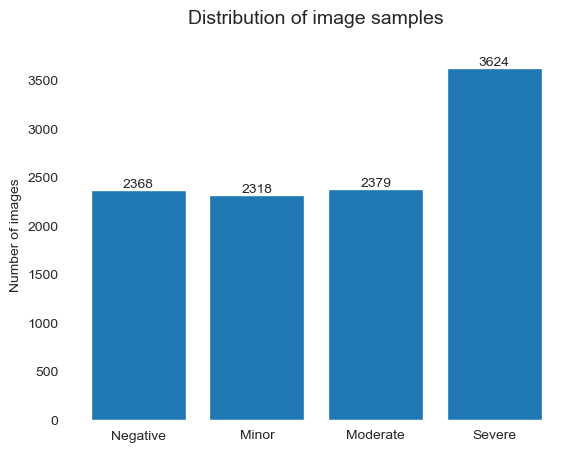

In [54]:
# Plot the distribution of the different classes

num_images = [len(data) for data in img_data.values()]

plt.bar(x = img_data.keys(), height = num_images)
plt.ylabel('Number of images', fontsize = 10)
plt.title('Distribution of image samples', fontsize = 14, y = 1.05)

for i, value in enumerate(num_images):
    plt.text(i, value+20, str(value), ha='center')

There are approximately 50% more images in the severe category than there are in any other category. This could encourage the model to bias predictions towards severe to increase accuracy. When creating the final dataset for the model, limit the number of severe images to 2400 to create a more balanced dataset

Plotting some typical classification examples to check the data looks correct

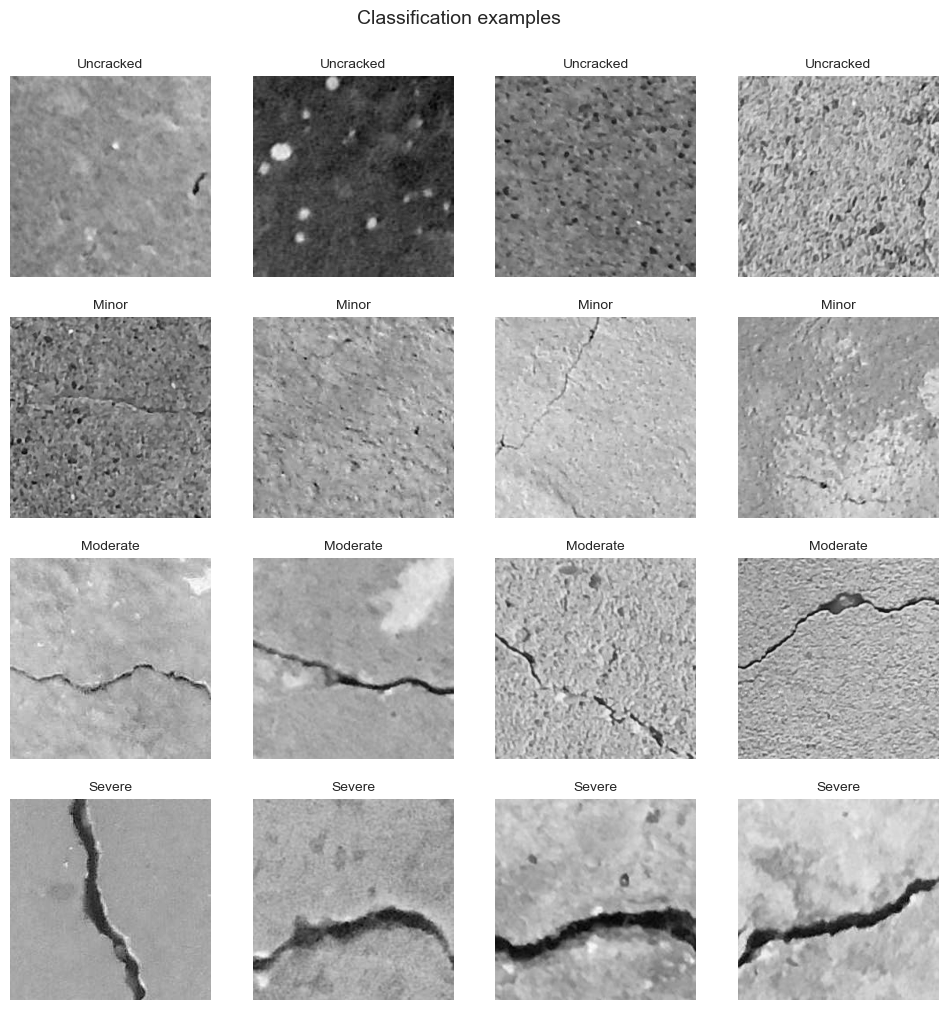

In [70]:
# Plotting a grid of example classifications

plt.figure(figsize=(12,12))

for i, folder in enumerate(folders):
    for j in range(4):
        plt.subplot(4, 4, (i*4)+j+1) # Plot in a 4x4 grid
        plt.imshow(img_data[folder][j*250], cmap = 'gray')
        plt.axis('off')
        plt.title(folder, fontsize = 10)
plt.suptitle('Classification examples', fontsize = 14, y = .935)
plt.show()

A selection of images from each of the four categories (rows) are shown above. The images are located at index 0, 250, 500, and 750 (columns)

Observations from the above:

- The images are clearly getting progressively more obvious cracking. 
- It appears that a lot of the images might be biased in terms of crack direction/orientation. 
- Some of the minor cracking images are very hard to spot and could be hard for the model to distinguish from the uncracked images. 

Look into minimum image size, image rotations, and contrast ratios to get an idea of how we could boost features in the images.

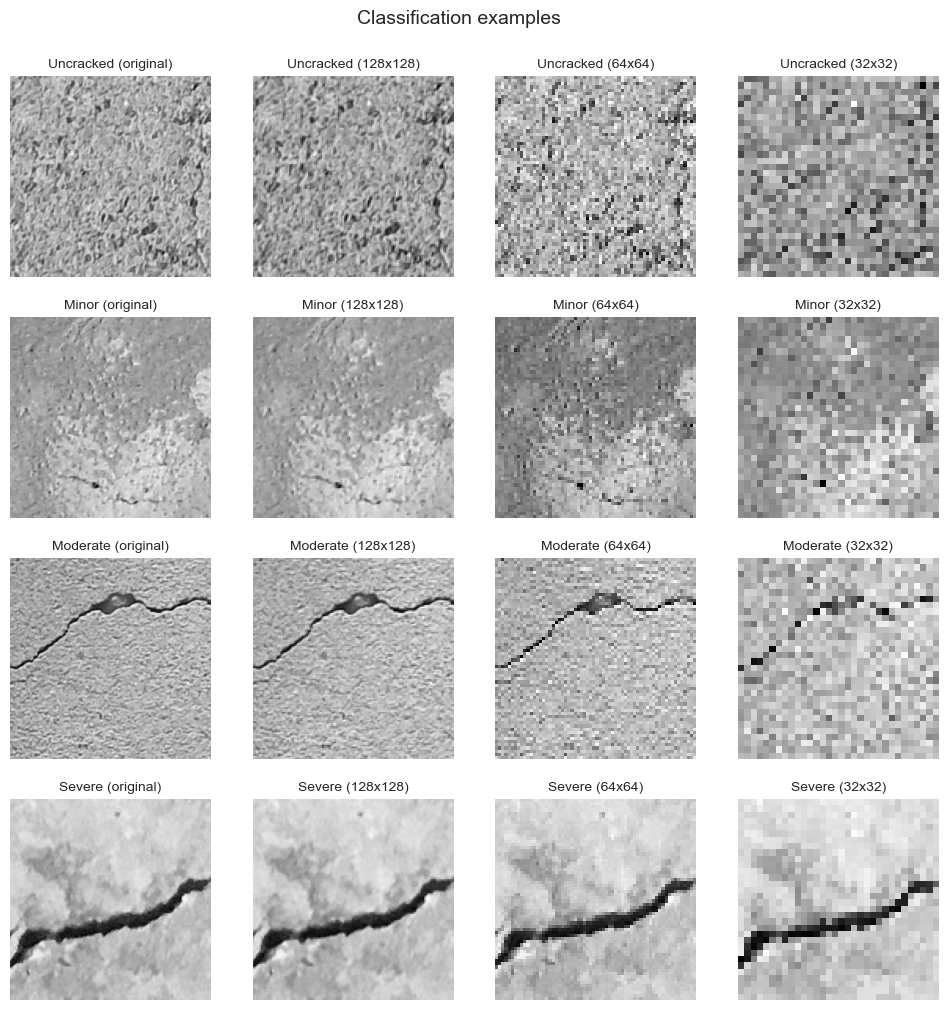

In [116]:
# Check if downsizing to 128x128, 64x64, and 32x32 pixel images will significantly affect detail

plt.figure(figsize=(12,12))

for i, folder in enumerate(folders):
    # Plot the original full size image
    plt.subplot(4, 4, (i*4) + 1) # Plot in a 4x3 grid
    plt.imshow(img_data[folder][750], cmap = 'gray')
    plt.axis('off')
    plt.title(f'{folder} (original)', fontsize = 10)

    # Plot a 128x128 image
    plt.subplot(4, 4, (i*4) + 2)
    plt.imshow(cv2.resize(img_data[folder][750], (128, 128)), cmap = 'gray')
    plt.axis('off')
    plt.title(f'{folder} (128x128)', fontsize = 10)

    # Plot a 64x64 image
    plt.subplot(4, 4, (i*4) + 3)
    plt.imshow(cv2.resize(img_data[folder][750], (64, 64)), cmap = 'gray')
    plt.axis('off')
    plt.title(f'{folder} (64x64)', fontsize = 10)

    # Plot a 64x64 image
    plt.subplot(4, 4, (i*4) + 4)
    plt.imshow(cv2.resize(img_data[folder][750], (32, 32)), cmap = 'gray')
    plt.axis('off')
    plt.title(f'{folder} (32x32)', fontsize = 10)


plt.suptitle('Classification examples', fontsize = 14, y = .935)
plt.show()


There is minimal loss of detail going from original size to 128x128 pixels. Quality drops significantly going to 64x64 and 32x32 pixels.

Adopt 128x128 pixel images for the final dataset as this has the advantage of significantly reducing the size of the input for reducing trainging time.

Check the effect of editing image contrast to hopefully amplify crack visibility in the minor cases. We can accomplish this by stretching out the image histograms to cover a greater range of values.

Try contrast enhacement with a contrast limited adaptive histogram. This will break the image down into smaller grids and adjust contrast within this smaller grid

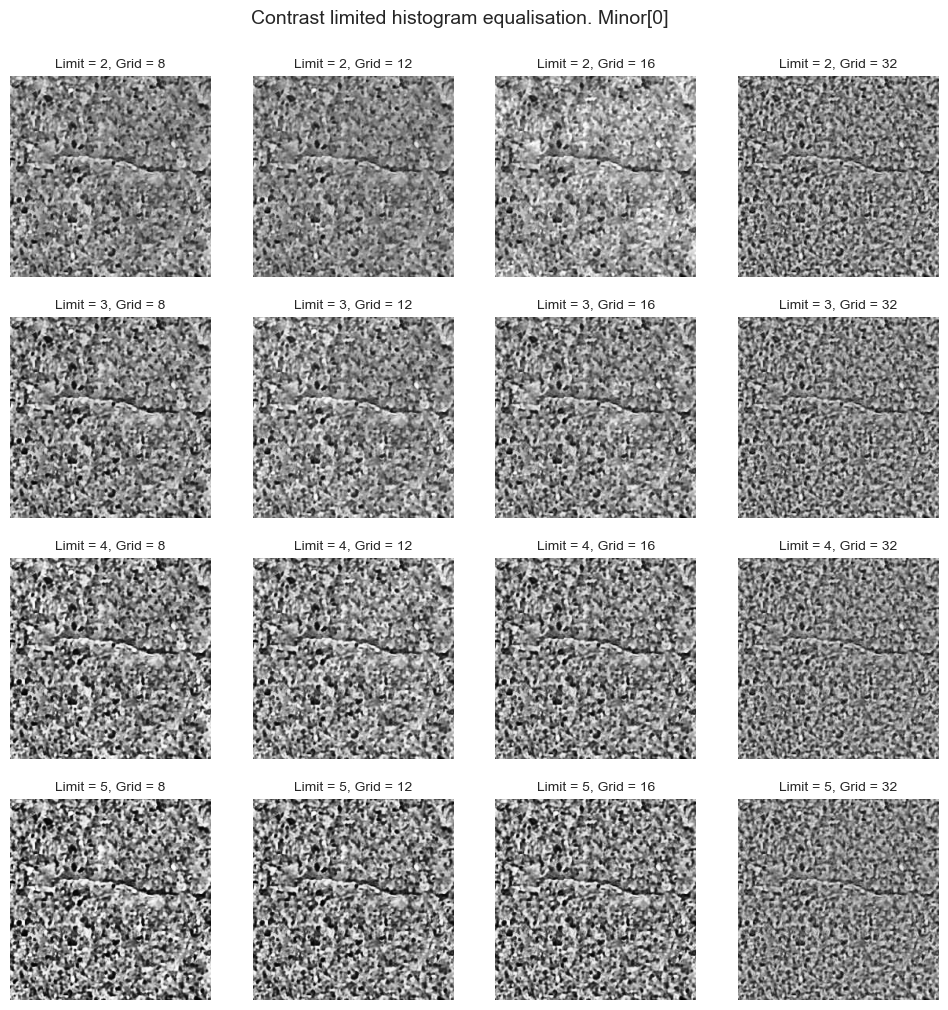

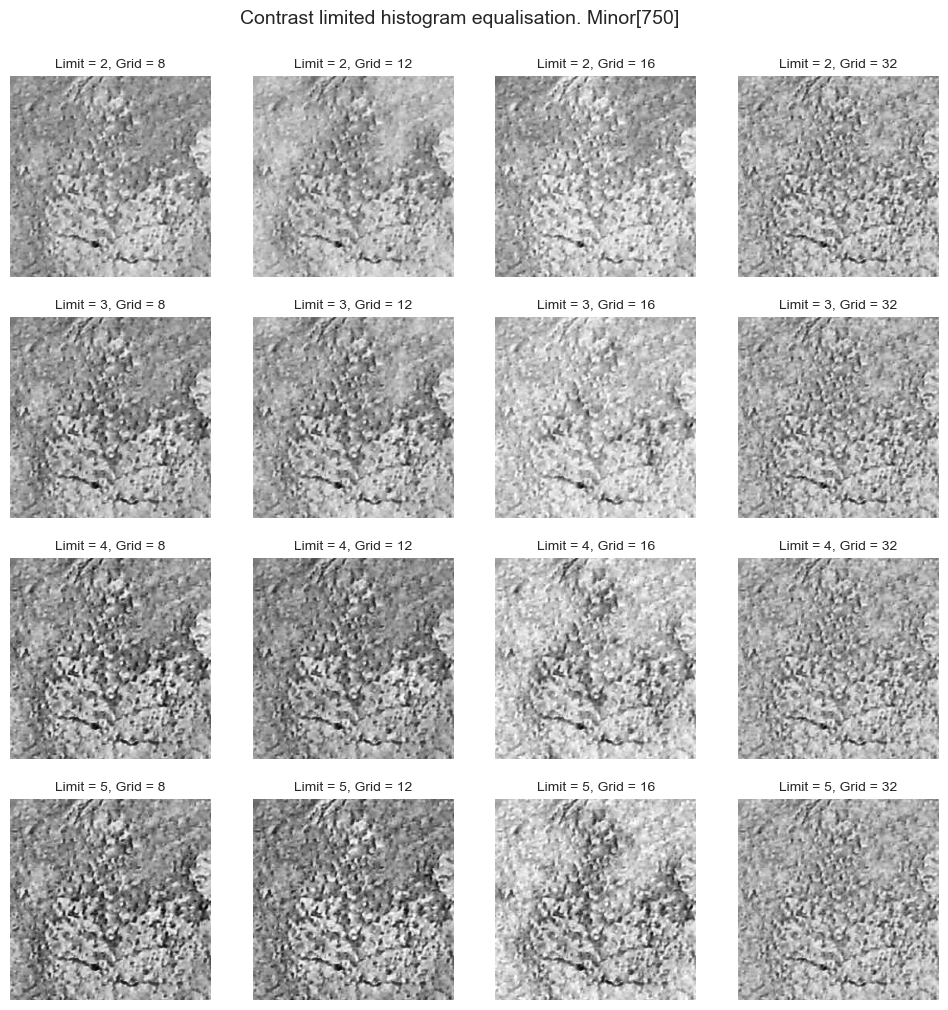

In [142]:
# Check the effect of editing the image contrast to hopefully amplify crack visibility in the minor cases
# Boost image contrast by stretching out the image histogram to cover a greater range
# Create a contrast limited adaptive histogram instance that will adapt contrast in 4x4 grids instead of over the whole image
# This will hopefully keep cracked parts dark and the rest of the image light

plt.figure(figsize = (12, 12))
grid = [8, 12, 16, 32]
limit = [2,3,4,5]

for i in range(4):
    for j in range(4):
        clahe = cv2.createCLAHE(clipLimit = limit[i], tileGridSize = (grid[j], grid[j]))
        plt.subplot(4, 4, (i*4)+j+1) # Plot in a 4x4 grid
        plt.imshow(clahe.apply(img_data['Minor'][0]), cmap = 'gray')
        plt.axis('off')
        plt.title(f'Limit = {limit[i]}, Grid = {grid[j]}', fontsize = 10)
plt.suptitle('Contrast limited histogram equalisation. Minor[0]', fontsize = 14, y = .935)
plt.show()

plt.figure(figsize = (12, 12))

for i in range(4):
    for j in range(4):
        clahe = cv2.createCLAHE(clipLimit = limit[i], tileGridSize = (grid[j], grid[j]))
        plt.subplot(4, 4, (i*4)+j+1) # Plot in a 4x4 grid
        plt.imshow(clahe.apply(img_data['Minor'][750]), cmap = 'gray')
        plt.axis('off')
        plt.title(f'Limit = {limit[i]}, Grid = {grid[j]}', fontsize = 10)
plt.suptitle('Contrast limited histogram equalisation. Minor[750]', fontsize = 14, y = .935)
plt.show()

The above shows the effect of using a contrast limiting approach when editing the image histogram using different grid sizes and different contrast limits within the grid. The method has been used on Minor cracked cases at index 0 and 750 which could be difficult to identify cracking amongst the noise in the image.

The effect works quite well for image at index 0, with the crack getting more visible in all combinations of grid and contrast limit.

The effect works well for image at index 0, specifically with the contrast limit = 3, and grid size = 16. The noise in the uncracked part of the image is reduced and the crack remains visible.

Adopt a contrast limit of 3 and a grid size of 16 when using this approach.

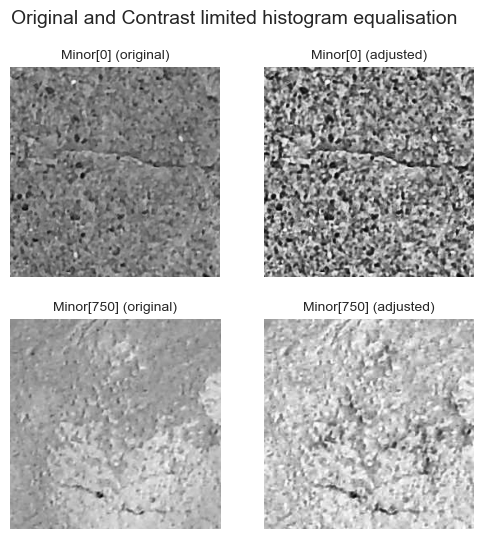

In [129]:
# Plot the before and after of the limited contrast limiting approach for both images

plt.figure(figsize = (6, 6))
clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize = (16, 16))

# Plot the original image index 0
plt.subplot(2, 2, 1)
plt.imshow(img_data['Minor'][0], cmap = 'gray')
plt.axis('off')
plt.title('Minor[0] (original)', fontsize = 10)

# Plot the adjusted image index 0
plt.subplot(2, 2, 2)
plt.imshow(clahe.apply(img_data['Minor'][0]), cmap = 'gray')
plt.axis('off')
plt.title('Minor[0] (adjusted)', fontsize = 10)

# Plot the original image index 750
plt.subplot(2, 2, 3)
plt.imshow(img_data['Minor'][750], cmap = 'gray')
plt.axis('off')
plt.title('Minor[750] (original)', fontsize = 10)

# Plot the adjusted image index 750
plt.subplot(2, 2, 4)
plt.imshow(clahe.apply(img_data['Minor'][750]), cmap = 'gray')
plt.axis('off')
plt.title('Minor[750] (adjusted)', fontsize = 10)

plt.suptitle('Original and Contrast limited histogram equalisation', fontsize = 14, y = .975)
plt.show()

There are clear differences between the original and altered images that could potentially make it easier for the model to distinguish.

We will explore the impact this feature engineering has on the accuracy of the data by training the models on both the stock image data and adjusted image data.

Check the effect of contrast enhancement by adjusting the image as a whole.

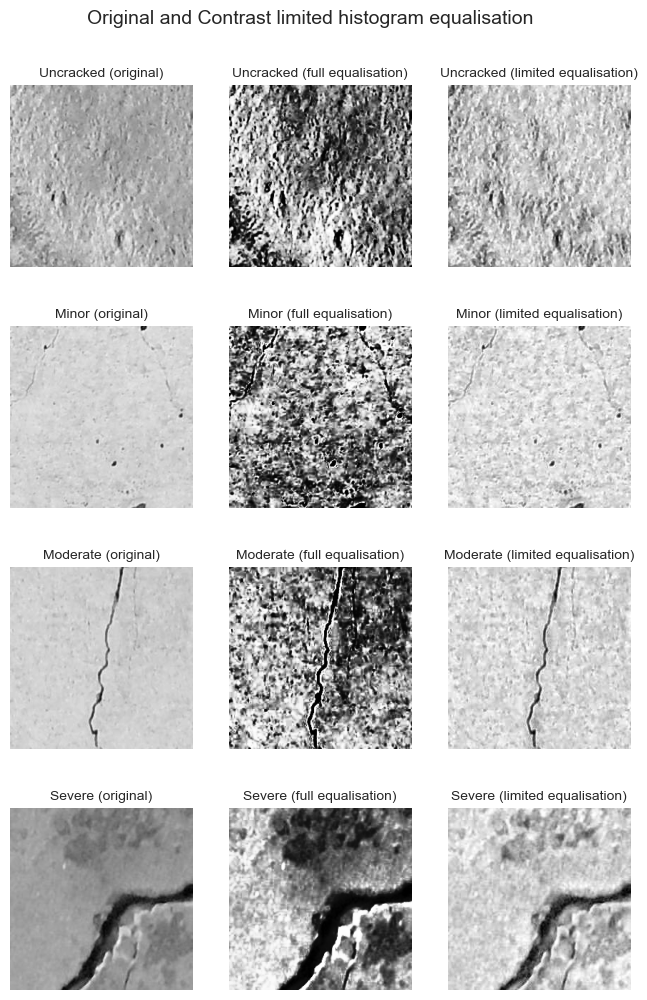

In [256]:
# Check the effect of editing the image contrast to hopefully amplify crack visibility
# Try the contrast limited approach from above as well as a contrast limiting approach that looks at the whole image 

plt.figure(figsize=(8,12))
index = 2000

# Create a contrast limited adaptive histogram instance that will adapt contrast in 4x4 grids instead of over the whole image
# This will hopefully keep cracked parts dark and the rest of the image light
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16, 16))

for i, folder in enumerate(folders):
    # Plot the original full size image
    plt.subplot(4, 3, (i*3) + 1) # Plot in a 4x3 grid
    plt.imshow(img_data[folder][index], cmap = 'gray')
    plt.axis('off')
    plt.title(f'{folder} (original)', fontsize = 10)

    # Plot an equalised histogram image
    plt.subplot(4, 3, (i*3) + 2)
    plt.imshow(cv2.equalizeHist(img_data[folder][index]), cmap = 'gray')
    plt.axis('off')
    plt.title(f'{folder} (full equalisation)', fontsize = 10)

    # Plot a contrast limited equalised histogram image
    plt.subplot(4, 3, (i*3) + 3)
    plt.imshow(clahe.apply(img_data[folder][index]), cmap = 'gray') 
    plt.axis('off')
    plt.title(f'{folder} (limited equalisation)', fontsize = 10)


plt.suptitle('Original and Contrast limited histogram equalisation', fontsize = 14, y = .935)
plt.show()

The limited equalisation appears to do a better job in removing noise and distinguishing features in the images.

Plot an image histogram to visualise what the contrast enhancement is doing to the image data

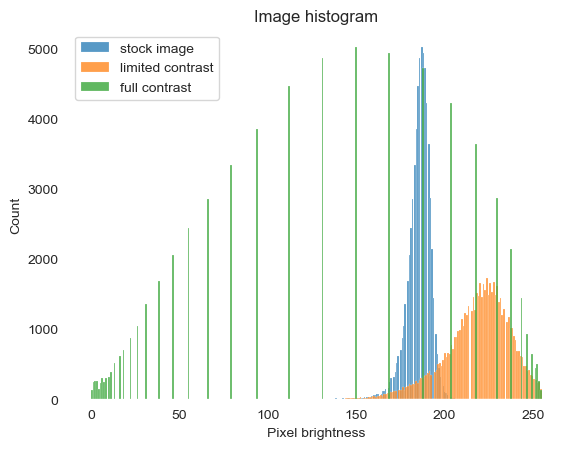

In [261]:
# Plot some sample histograms
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16, 16))
image = (img_data['Minor'][2000])
full = cv2.equalizeHist(image)
limited = clahe.apply(image)

df = pd.DataFrame({'stock': image.flatten(), 'limited': limited.flatten(), 'full': full.flatten()})

sns.histplot(data=df['stock'], label='stock image', bins = 256)
sns.histplot(data=df['limited'], label='limited contrast', bins = 256)
sns.histplot(data=df['full'], label='full contrast', bins = 256)
plt.xlabel('Pixel brightness')
plt.title('Image histogram')
plt.legend();

The stock image data in blue is very tightly packed around pixel intensities of around 175. This could be difficult for the model to distinguish between features of interest in the data.

The limited contrast adjustment has a much better distribution data points with bright points getting brighter while keeping dark points approximately the same.

The full contrast adjustment has stretched the values out over the full range of values from 0 - 255. This has created big holes in the histogram since there is not enough variation in the original image to fill all values. This creates the appearance of image noise.

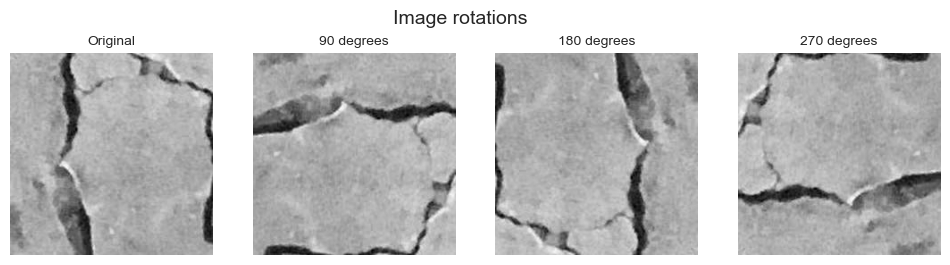

In [141]:
# Try some image rotations to better generalise the model.

plt.figure(figsize=(12,3))
image = img_data['Severe'][50]

# Plot the original image
plt.subplot(1, 4, 1)
plt.imshow(image, cmap = 'gray')
plt.axis('off')
plt.title('Original', fontsize = 10)

# Rotate 90 degrees clockwise
plt.subplot(1, 4, 2)
plt.imshow(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE), cmap = 'gray')
plt.axis('off')
plt.title('90 degrees', fontsize = 10)

# Rotate 180 degrees
plt.subplot(1, 4, 3)
plt.imshow(cv2.rotate(image, cv2.ROTATE_180), cmap = 'gray')
plt.axis('off')
plt.title('180 degrees', fontsize = 10)


# Rotate 90 degrees counter-clockwise
plt.subplot(1, 4, 4)
plt.imshow(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), cmap = 'gray')
plt.axis('off')
plt.title('270 degrees', fontsize = 10)


plt.suptitle('Image rotations', fontsize = 14, y = .975)
plt.show()

Images will have to be rotated in multiples of 90 degrees to make sure that the cracks on the corners of the images are not lost and ruin the labelling of the image.

This should hopefully make the model generalise better.